# TDT4173 - Machine Learning
Names: Jacob Alexander Worsøe, Henrik August Søntvedt, Simen Øygarden Burgos

Student IDs: 544553, 543969, 543917

Team name: 5tabekk

Team number: 5



## Long Notebook 

We worked with a system where we created a python library containing helper functions. These have been placed below and adapted to the notebook format. This library also contained a MetaModel class that we created to more easily test and keep track of our models. This is why our models are written into classes.


### 1. Setup


#### Data location

We kept the data in a folder titled data as follows
 - data
    - A
    - B
    - C

In [ ]:
data_dir = './data/'


#### Imports

In [ ]:
import os

import pandas as pd
import numpy as np

from abc import ABC, abstractmethod
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error
import statistics

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

import sys
import random
import math
from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.linear_model import LinearRegression


from keras import models, layers, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf

import lightgbm as lgbm

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

from sklearn.decomposition import PCA


import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

from prophet import Prophet

import xgboost as xgb

from itertools import combinations


#### Data fetching and preprocessing functions

In [ ]:

def get_training():
    """ gets full training data (duh) """

    train_a = pd.read_parquet(data_dir + 'A/train_targets.parquet')
    train_b = pd.read_parquet(data_dir + 'B/train_targets.parquet')
    train_c = pd.read_parquet(data_dir + 'C/train_targets.parquet')

    X_train_estimated_a = pd.read_parquet(data_dir + 'A/X_train_estimated.parquet')
    X_train_estimated_b = pd.read_parquet(data_dir + 'B/X_train_estimated.parquet')
    X_train_estimated_c = pd.read_parquet(data_dir + 'C/X_train_estimated.parquet')

    X_train_observed_a = pd.read_parquet(data_dir + 'A/X_train_observed.parquet')
    X_train_observed_b = pd.read_parquet(data_dir + 'B/X_train_observed.parquet')
    X_train_observed_c = pd.read_parquet(data_dir + 'C/X_train_observed.parquet')

    ret = pd.DataFrame()
    ret.set_index(pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['location', 'datetime']), inplace=True)
    ret.columns = pd.MultiIndex(levels=[[],[], []], codes=[[],[], []], names=['feature_type', 'minutes', 'feature_name'])


    # estimated data
    data_dict = {'A': X_train_estimated_a, 'B': X_train_estimated_b, 'C': X_train_estimated_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_calc', 'date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['estimated'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])

    # observed data
    data_dict = {'A': X_train_observed_a, 'B': X_train_observed_b, 'C': X_train_observed_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['observed'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])
        


    # # train data
    data_dict = {'B': train_b, 'C': train_c} # 'A': train_a, 

    out_temp = train_a.dropna().copy()
    out_temp.rename(columns={'time': 'datetime'}, inplace=True)
    out_temp.set_index('datetime', inplace=True)
    out_temp.columns = pd.MultiIndex.from_product([['y'], ['NA'], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

    out_temp.set_index(pd.MultiIndex.from_product([['A'], out_temp.index], names=['location', 'datetime']), inplace=True)

    for loc in data_dict:

        out_temp2 = data_dict[loc].dropna().copy()
        out_temp2.rename(columns={'time': 'datetime'}, inplace=True)
        out_temp2.set_index('datetime', inplace=True)
        out_temp2.columns = pd.MultiIndex.from_product([['y'], ['NA'], out_temp2.columns], names=['feature_type', 'minutes', 'feature_name'])

        out_temp2.set_index(pd.MultiIndex.from_product([[loc], out_temp2.index], names=['location', 'datetime']), inplace=True)

        out_temp = pd.concat([out_temp, out_temp2])

        # ret = ret.merge(out_temp, left_index=True, right_index=True, how='outer')
        # ret = pd.concat([ret, out_temp])
        

    ret = pd.merge(out_temp, ret, left_index=True, right_index=True, how='outer')

    return ret


def get_training_groupby_mean():
    return get_training().groupby(level = [0,2], axis = 1).mean()[['y', 'estimated', 'observed']]


def get_training_flattened():
    df = get_training_groupby_mean()

    df['estimated', 'weather_data_type'] = np.nan

    df['estimated', 'weather_data_type'] = np.where(df['observed', 'absolute_humidity_2m:gm3'].notna(),'observed', df['estimated', 'weather_data_type'])
    df['estimated', 'weather_data_type'] = np.where(df['estimated', 'absolute_humidity_2m:gm3'].notna(),'estimated', df['estimated', 'weather_data_type'])
    df.estimated = df.estimated.fillna(df.observed)

    df = df.drop(columns=['observed'], level=0)
    df.columns = df.columns.droplevel().tolist()
    df.reset_index(inplace=True)
    df.rename(columns={'datetime': 'ds', 'pv_measurement': 'y'}, inplace=True)
    # df['ENG_total_rad'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']
    
    return df[['location', 'ds', 'y', 'weather_data_type'] + [i for i in df.columns.tolist() if i not in ['location', 'ds', 'y', 'weather_data_type']]].copy()

def get_training_cleaned():
    df = get_training_flattened()

    df = df[
            ~((df.y != 0) & 
            (df.y == df.y.shift(-1)) &
            (df.y == df.y.shift(-2)))
        ].copy()

    df.dropna(axis=0, subset='y', inplace=True)

    return df


### Testing

def get_testing():
    """ gets the feature estimates used for the forecast """

    X_test_estimated_a = pd.read_parquet(data_dir + 'A/X_test_estimated.parquet')
    X_test_estimated_b = pd.read_parquet(data_dir + 'B/X_test_estimated.parquet')
    X_test_estimated_c = pd.read_parquet(data_dir + 'C/X_test_estimated.parquet')

    ret = pd.DataFrame()
    ret.set_index(pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=['location', 'datetime']), inplace=True)
    ret.columns = pd.MultiIndex(levels=[[],[], []], codes=[[],[], []], names=['feature_type', 'minutes', 'feature_name'])


    # estimated data
    data_dict = {'A': X_test_estimated_a, 'B': X_test_estimated_b, 'C': X_test_estimated_c}

    for loc in data_dict:
        out_temp = pd.DataFrame(data_dict[loc].date_forecast.dt.floor('H').unique(), columns=['date_forecast'])
        out_temp.set_index('date_forecast', inplace=True)
        out_temp.columns = pd.MultiIndex.from_product([[], [], out_temp.columns], names=['feature_type', 'minutes', 'feature_name'])

        for m in [0, 15, 30, 45]:
            temp = data_dict[loc][data_dict[loc].date_forecast.dt.minute == m].copy()
            temp.set_index(temp.date_forecast.dt.floor('H'), inplace=True)
            temp.drop(columns=['date_calc', 'date_forecast'], inplace=True)
            temp.columns = pd.MultiIndex.from_product([['estimated'], [m], temp.columns], names=['feature_type', 'minutes', 'feature_name'])
            out_temp = out_temp.merge(temp,left_index=True, right_index=True, how='outer')

        out_temp.set_index(pd.MultiIndex.from_product([[loc], out_temp.index], names=['location', 'datetime']), inplace=True)
        ret = pd.concat([ret, out_temp])

    return ret


def get_testing_flattened():
    df = get_testing()
    df = df.groupby(level = [0,2], axis = 1).mean()[['estimated']]
    df.columns = df.columns.droplevel().tolist()
    df.reset_index(inplace=True)
    df.rename(columns={'datetime': 'ds'}, inplace=True)
    df['weather_data_type'] = 'estimated'
    return df[['location', 'ds', 'weather_data_type'] + [i for i in df.columns.tolist() if i not in ['location', 'ds', 'y', 'weather_data_type']]]


#### Other helper functions

In [ ]:
### Interpolation for nan values
def interpolate_na(df: pd.DataFrame, cols: list, inplace=True):
    if inplace:
        for col in cols:
            df[col].ffill(inplace=True)
            df[col].bfill(inplace=True)

            df[col].interpolate(inplace=True)   

            df[col].fillna(df[col].cummax(), inplace=True)

    else:
        new_df = None
        for col in cols:
            new_df = df[col].ffill(inplace=inplace)
            new_df = df[col].bfill(inplace=inplace)

            new_df = df[col].fillna(df[col].interpolate().cummax(), inplace=inplace)

        return new_df

### Maps hour values
def map_hour_to_seasonal(df, hour_col):
    mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6,
               7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12,
               13: 11, 14: 10, 15: 9, 16: 8, 17: 7, 18: 6,
               19: 5, 20: 4, 21: 3, 22: 2, 23: 1, 24: 0,}
    df[hour_col].replace(mapping, inplace=True)

### Maps month values
def map_month_to_seasonal(df, month_col):
    mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6,
               7: 5, 8: 4, 9: 3, 10: 2, 11: 1, 12: 0}
    
    df[month_col].replace(mapping, inplace=True)

### Predictions to csv - used in make_submittable
def y_pred_to_csv(file_name, df):
    df[['y_pred']].reset_index(drop=True).reset_index().rename(columns={'index': 'id', 'y_pred': 'prediction'}).to_csv(module_dir + "/../submissions/" + file_name, index=False)


### Generates a csv file for submission
def make_submittable(file_name, model = None, model_dict = None):
    """
    model if same model used for all locations
    model dict if not

    model is instance of model (model = MetaModel())
    model dict uses location as key ({"A": MetaModel(), "B": MetaModel(), "C": MetaModel()})
    """

    df = data.get_training_cleaned()
    test = data.get_testing_flattened()
    ret = pd.DataFrame()
    
    for location in ['A', 'B', 'C']:
        temp_df = df[df['location']==location]
        temp_test = test[test['location']==location]

        if model is not None:
            m = model
        elif model_dict is not None:
            m = model_dict[location]
        else:
            raise ValueError("no model specified")
    
        m.train(temp_df)
        fcst = m.predict(temp_test)

        ret = pd.concat([ret, fcst])

    y_pred_to_csv(file_name, ret)

### 2. Avoiding Deductions

#### 2.1 Exploratory Data Analysis

##### 2.1.1 Search domain knowledge

Given the available weather features, our approach was to understand how the distinct features impacted solar energy generation. Solar panels convert solar energy to electrical energy, so the amount of energy produced is a function of solar irradiance - the amount of solar energy hitting the panels.

Next, we researched which features could impact the amount of solar energy hitting the panels, identifying these key factors:
- direct radiation, measured by direct_rad_1h:J and direct_rad:W
- indirect radiaton, measured by diffuse_rad_1h:J and diffuse_rad:W
- shading, measured by is_in_shadow:idx
- clouding, measured by total_cloud_cover:p
- angle of the sun compared to panels, measured by sun_azimuth:d and sun_elevation:d
- particles such as snow covering the panels, measured by the fresh_snow variables

In addition, we identified panel degradation as a factor impacting the energy output of the solar panels, potentially making their efficiency worse over time.

##### 2.1.2 Check if the data is intuitive


a. Solar energy generation should follow a yearly cycle, with the highest production during summer months assuming that the plants are located on the northern hemisphere. This seems to be the case for all three locations:

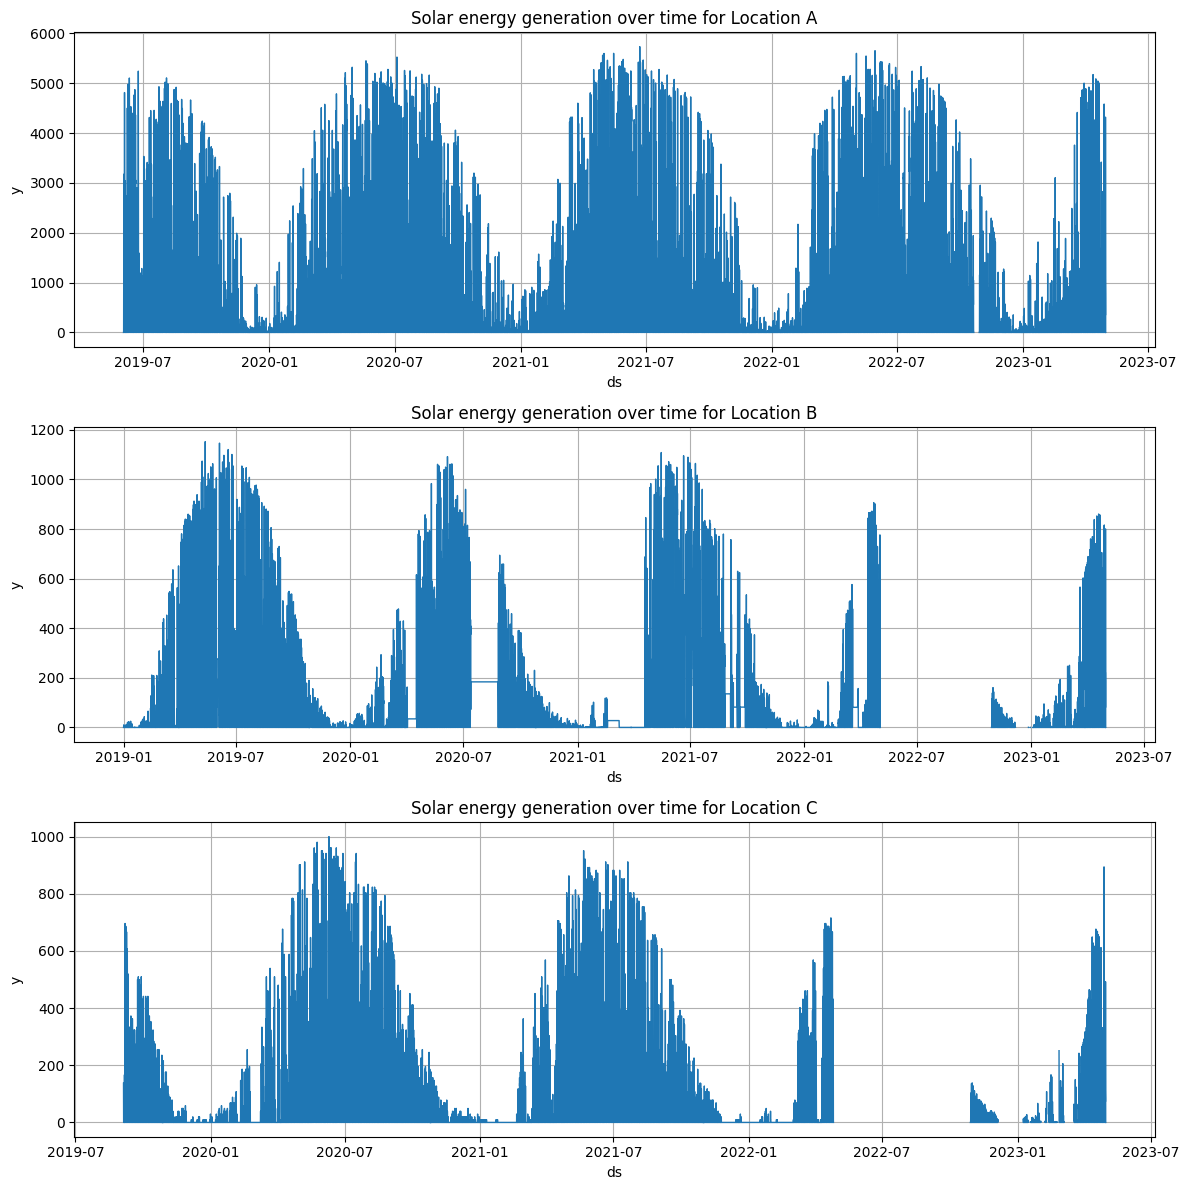

b. Energy generation should be (near) zero when the sun is below the horizon, so sun elevation is plotted against y. Except for some data in the uncleaned training data for location B, this seems to be the case:

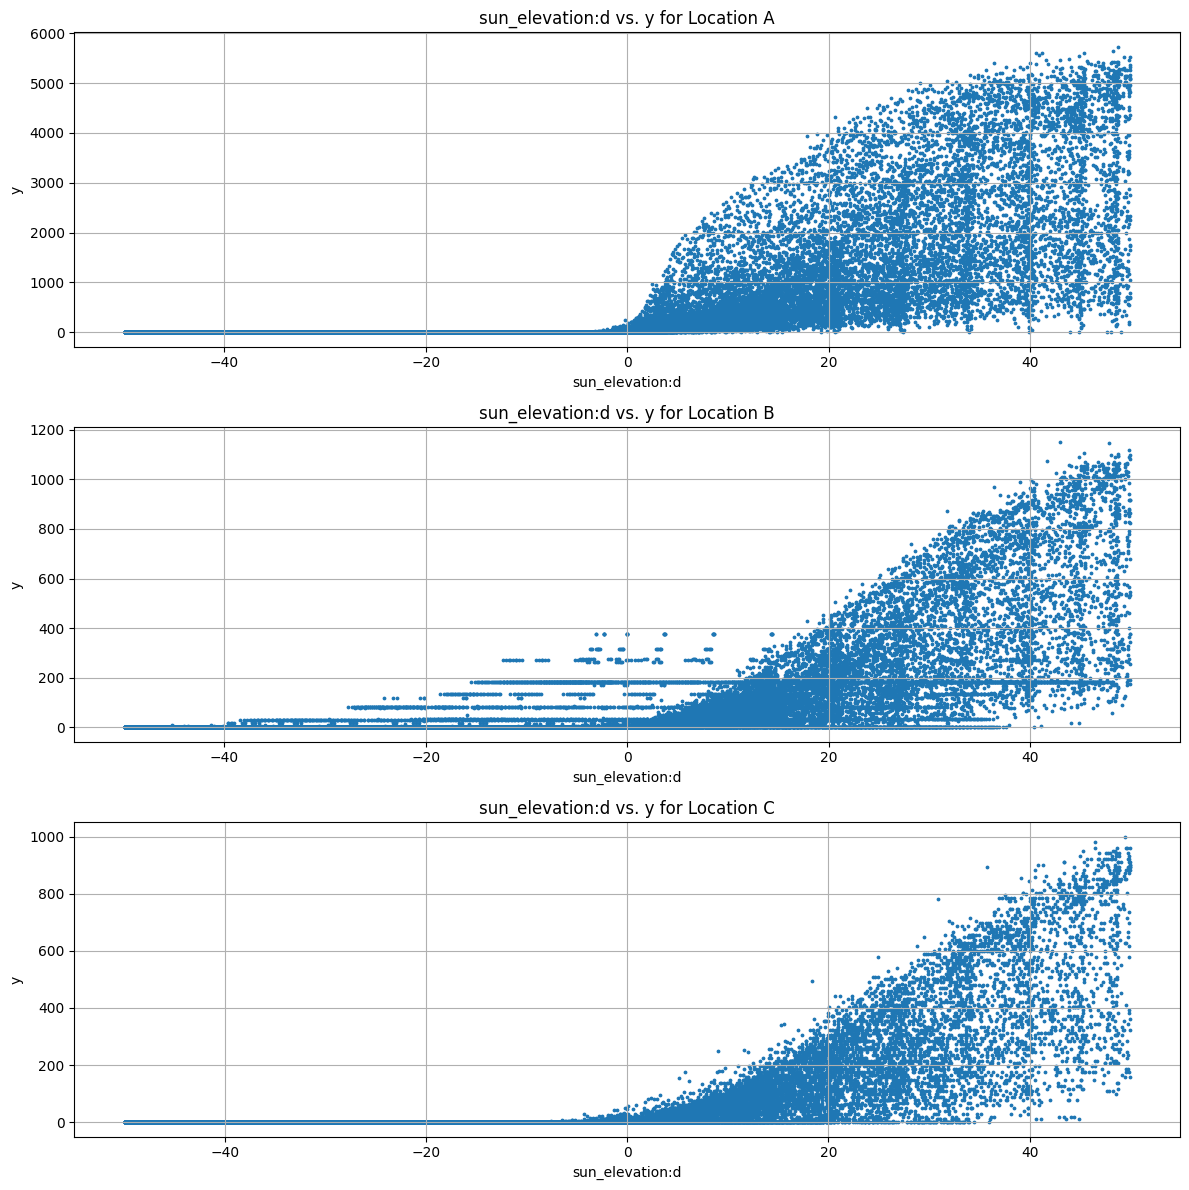

c. Snow depth should be the highest during winter months, which seems to be the case for all locations: 

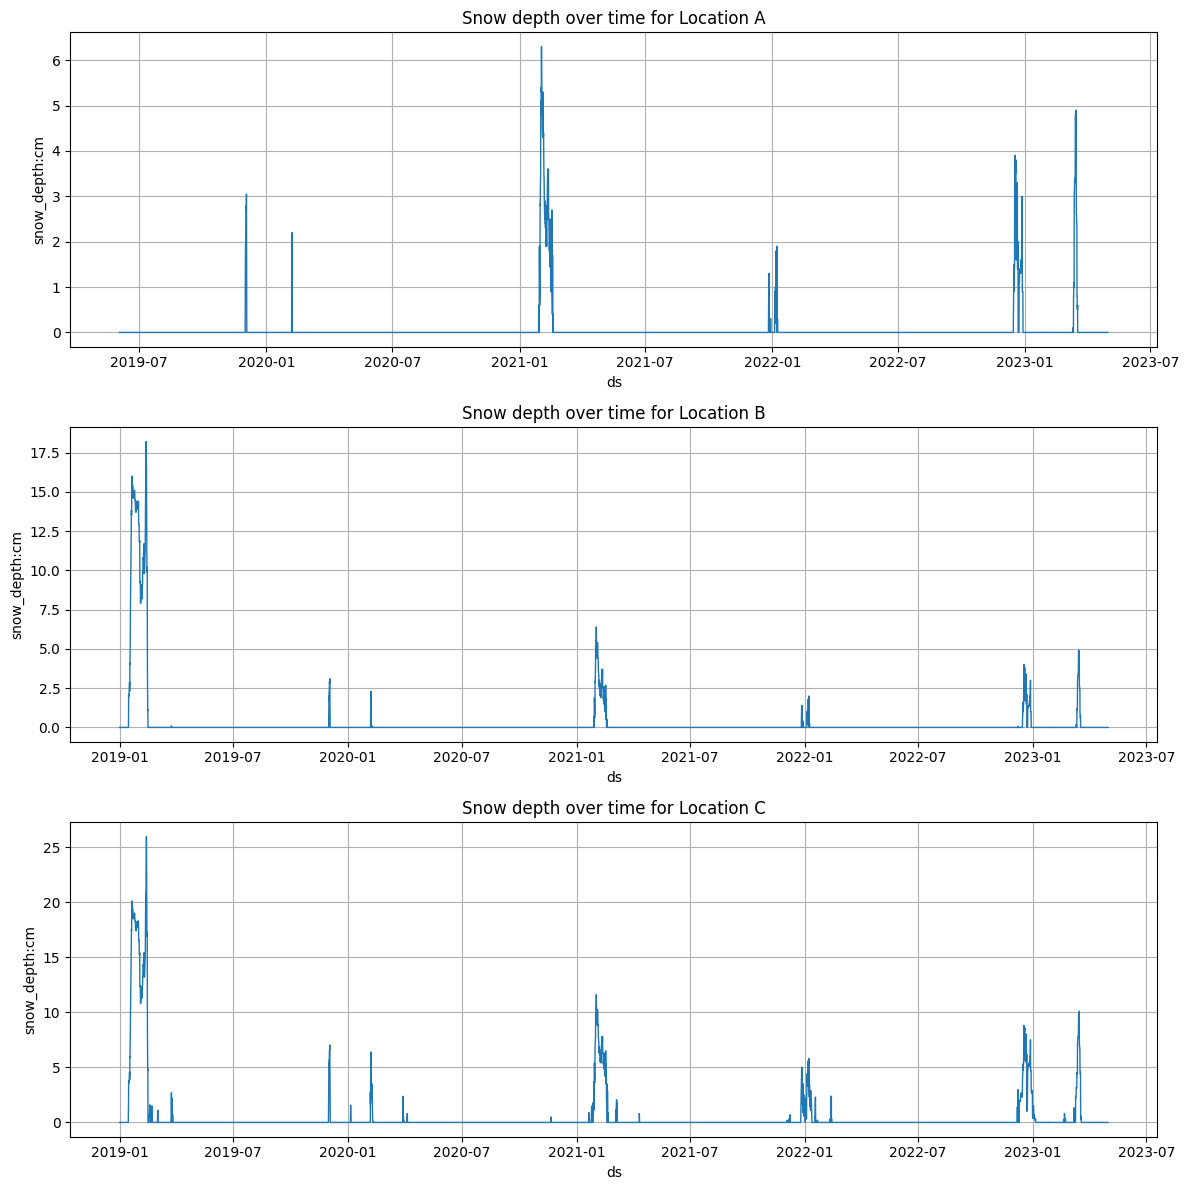

d. Energy generation should be the highest during daytime, when the sun is stronger. To verify this intuition, we plotted the average energy generation for each hour of the day for Location A: 

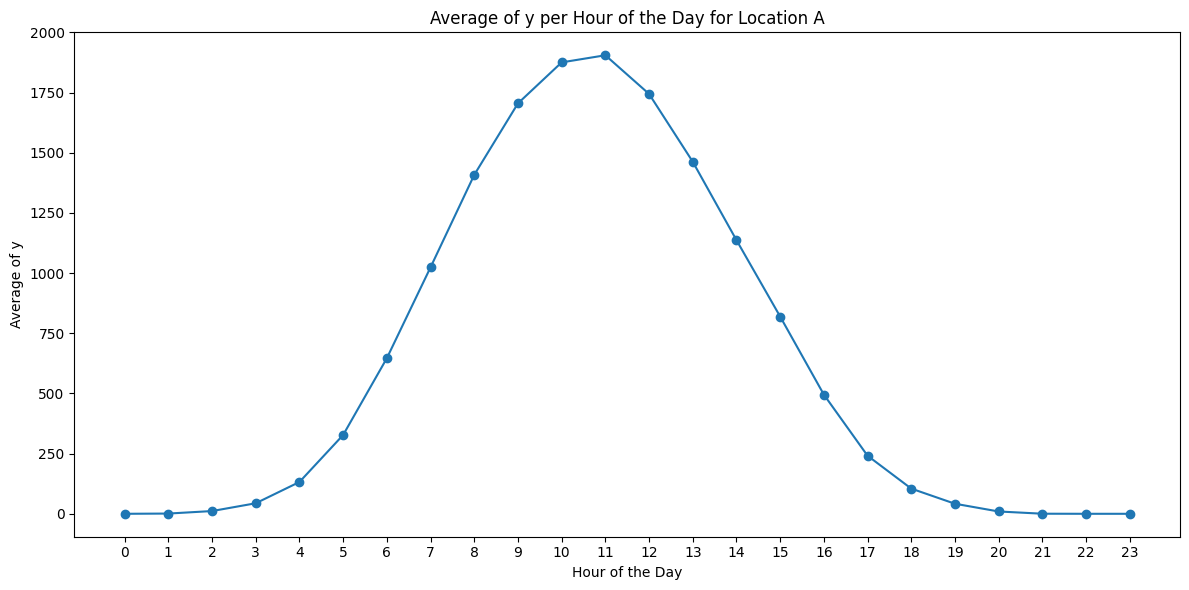

##### 2.1.3 Understand how the data was generated 


The weather features given in the dataset are mostly generated through various meteorological instruments and sensors. 

Here is our understanding of how some key weather features were generated: 
- diffuse solar radiation, measured with a pyranometer
- direct solar radiation, measured with a pyrheliometer
- snowfall / snow depth, measured with a snow gauge 
- pressure,  measured with barometers
- precipitation, measured with a rain gauge

##### 2.1.4 Explore individual features

a. Percentage of shadow for each hour in the day (using 'is_in_shadow:idx')

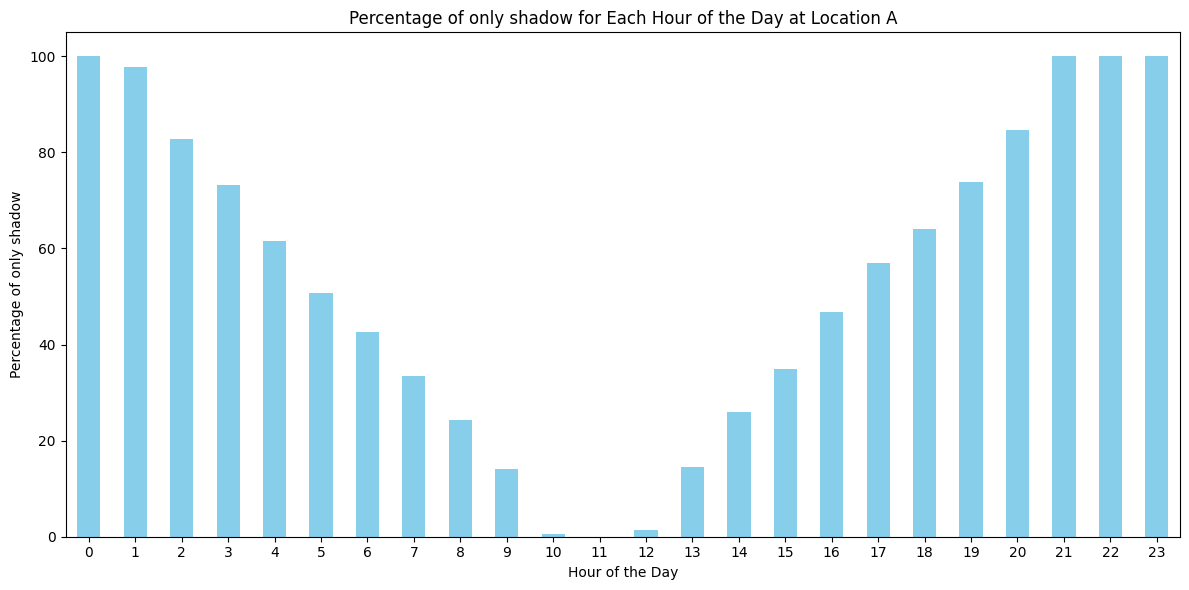

b. Sun elevation over time (using 'sun_elevation:d'). As expected, the sun is higher over the horizon in the summer months, and it follows a yearly cycle.

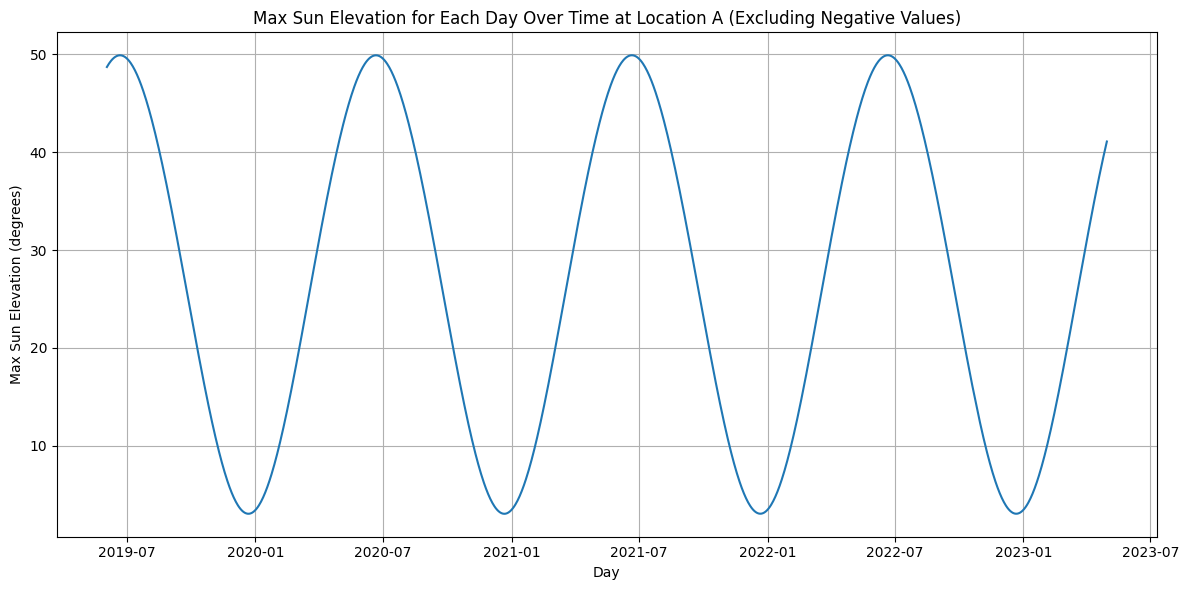

c. Proportion of days with snow (using 'snow_depth:cm')

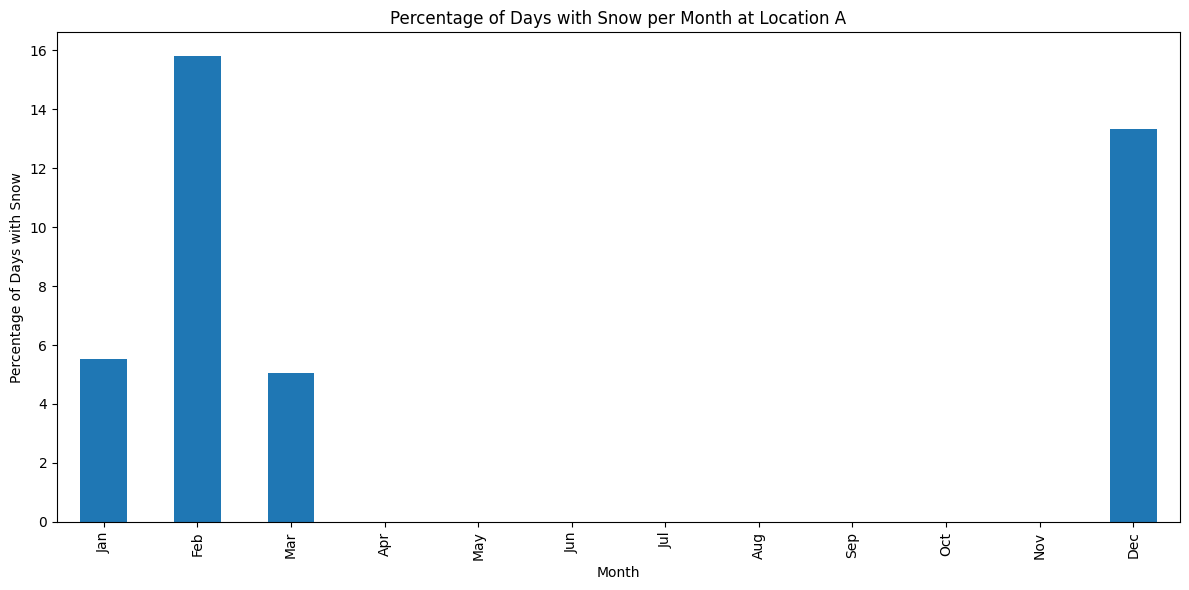

##### 2.1.5 Explore pairs and groups of features 


a. Correlation matrix of pv_measurement (y) with five selected weather features. The conclusion is that solar energy generation is positively correlated with diffuse radiation, direct radiation, and sun elevation, but negatively correlated with shadow and snow depth.

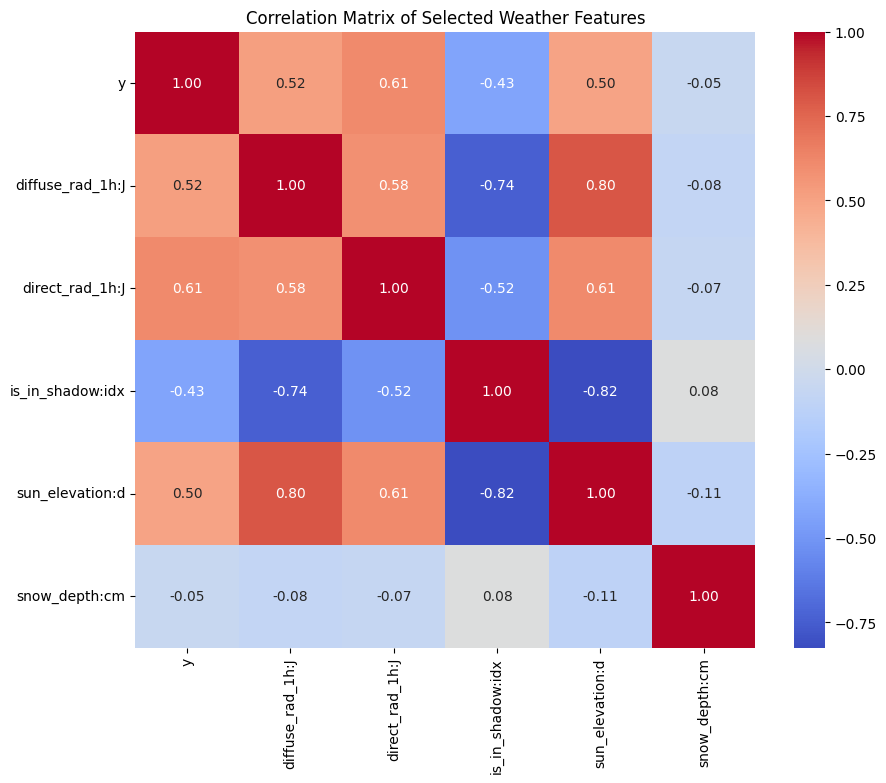

b. Pressure variables. We see that the four pressure variables are highly correlated and follow the same pattern.

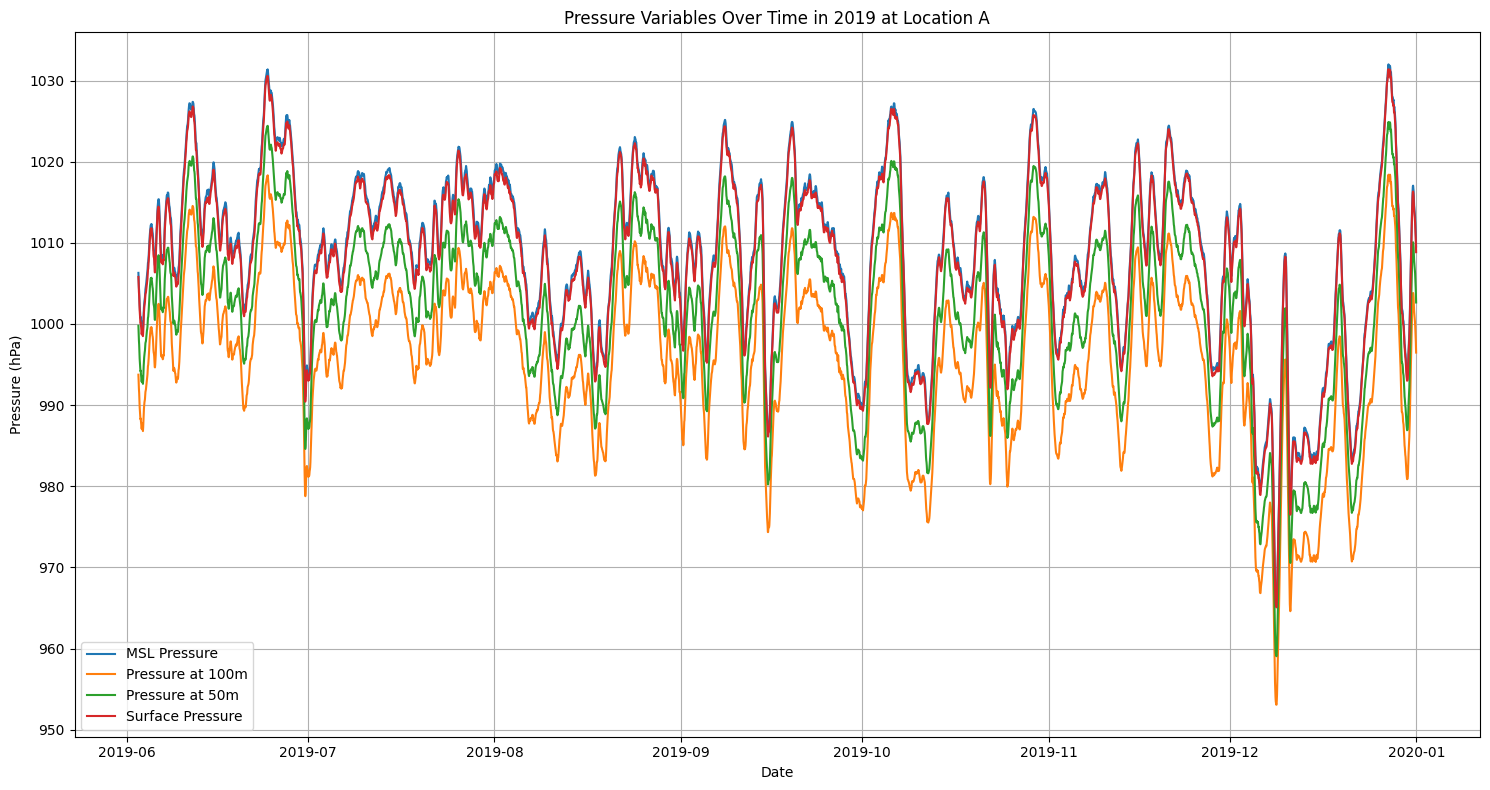

c. Scatter plot of direct radiation vs. sun azimuth angle. We see that the direct radiation is highest when the azimuth angle is around 180 degrees, that is when the sun hits directly on the solar panels. 


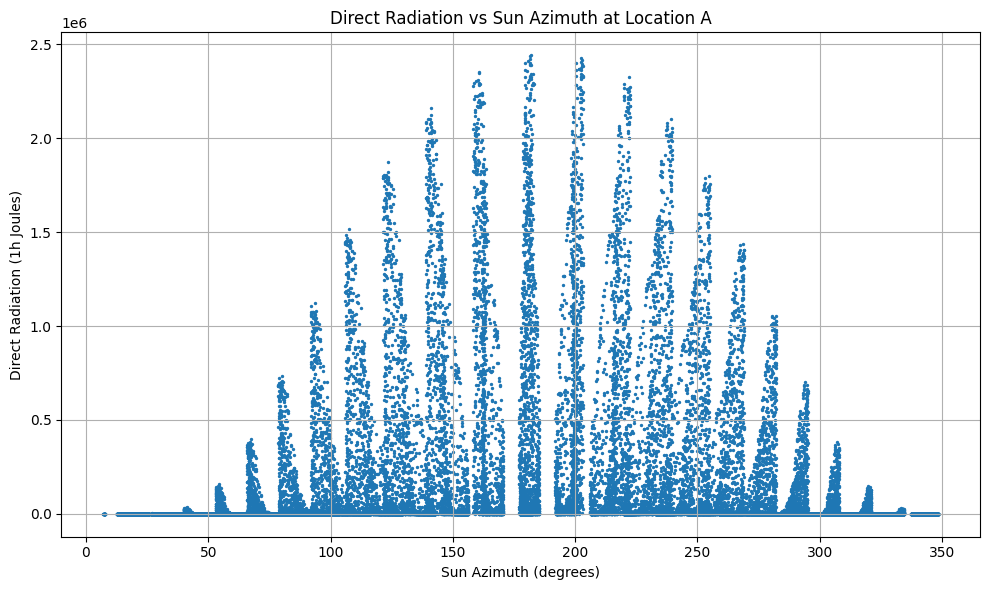

##### 2.1.6 Clean up features 


For all training data, the following data cleaning is performed:

1. Remove rows where the energy generation value is missing (dropna)


2. Exclude rows where energy generation is not zero and has the exact same value for the next two rows.

    This was decided after detecting that many consecutive pv_measurement values were equal for location B. 
    The aim of excluding these rows is to improve test accuracy by avoiding training on faulty target values.


In [ ]:
### Python code for data cleaning done across all models
"""
def get_training_cleaned():
    df = get_training_flattened()

    df = df[
            ~((df.y != 0) & 
            (df.y == df.y.shift(-1)) &
            (df.y == df.y.shift(-2)))
        ].copy()

    df.dropna(axis=0, subset='y', inplace=True)

    return df
"""

Additional preprocessing is implemented on a per-model basis.

One example of data cleaning done in the preprocessing function for several of our models, is that missing values are handled by filling in 0 values using temp_df.fillna(0, inplace=True). 

This is the case for both our catboost and xg_boost models.

#### 2.2 Predictors

Two examples of predictors used: 

1. Linear regression - see model 2

    Simple linear regression model using total radiation (direct + diffuse) as the independent variable and pv_measurement as the target variable.

2. XGBoost (eXtreme Gradient Boosting) - see model 4 and 5

     Uses gradient boosting to build an ensemble of decision trees, each trained on a subset of the data. The final prediction is a combination of the individual predictions from distinct trees.

Additional predictors can be found in section 3. Models.

#### 2.3 Feature Engineering

##### 2.3.1 Feature Selection

Based on initial EDA, several of the original features were excluded:

- elevation was discarded since this is constant across a single location, and we made different models for each location

- of the five fresh_snow columns, all except fresh_snow_3h:cm were discarded. This decision was based on the fact that all the fresh_snow variables were almost only zero in the whole test period of summer months. 

- snow density, depth, drift and melt were also exluded since these features had all zero values in the relevant prediction period.

- of the three pressure variables, all except sfc_pressure were discarded. This was due to a very high correlation between the three.

In [4]:
### Initial columns in df prior to feature selection
"""
Index(['location', 'ds', 'y', 'weather_data_type', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'total_rad_1h:J'],
      dtype='object')
"""
### Columns in cat_composite after feature selection and feature extraction/addition
"""
self.common_features = ['sample_importance', 'is_estimated','dayofyear',
                                'is_day:idx',
                             'hour', 'month',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
self.random_features = ['absolute_humidity_2m:gm3',
                                'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                                'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                                'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
                                'direct_rad_1h:J', 'fresh_snow_3h:cm',
                                'precip_5min:mm','precip_type_5min:idx', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                                'sfc_pressure:hPa','snow_water:kgm2',
                                'super_cooled_liquid_water:kgm2',
                                't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                                'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
"""                               


"\nself.common_features = ['sample_importance', 'is_estimated','dayofyear',\n                                'is_day:idx',\n                             'hour', 'month',\n                            'total_rad_1h:J',\n                            'sun_elevation:d',\n                            'sun_azimuth:d',\n                            'is_in_shadow:idx',\n                            'effective_cloud_cover:p']\n        \nself.random_features = ['absolute_humidity_2m:gm3',\n                                'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',\n                                'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',\n                                'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',\n                                'direct_rad_1h:J', 'fresh_snow_3h:cm',\n                                'precip_5min:mm','precip_type_5min:idx', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',\n                        

##### 2.3.2 Feature Extraction/Addition

Based on initial EDA and our understanding of which features in the original data have the highest impact on solar energy production, the following features were generated:

- total_rad_1h:J = diffuse_rad_1h:J + direct_rad_1h:J. Solar energy generation is highly correlated with the total amount of sunlight energy hitting the panels, equaling the sum of diffuse and direct radiation, so we added a total column.

- sample_importance was added in order to overfit our model to the relevant prediction period, giving hours in the relevant period a sample importance of 2 compared to 1 for other rows.

- is_estimated was added to take into account whether the independent weather features were observed (certain) or estimated (uncertain).

- month, dayofyear, and hour were added as new columns based on the datetime (ds) column. This decision was due to the fact that both the time of year and time of day were highly correlated with pv_measurement.

In [ ]:
### Preprocessing example from catboost_henrik
"""
def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns        
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

         # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['month'] = temp_df['ds'].dt.month
        temp_df['month'] = (np.sin(2 * np.pi * (temp_df['month'])/ 12) + 1) / 2


        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO XGBOOST
        temp_df.fillna(0, inplace=True)

        #####################################################################################

        # DROPPING UNEEEDED FEATURES
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df
"""

#### 2.4 Model Interpretation - CatBoost

Interpretation of one of the two top-scoring models. Further details about the model can be found in the short notebook.

##### 2.4.1 Feature Importance

Below we list out the most important features found by CatBoost. The most important features are reflected in the common feature-set that each of the individual CatBoost models use. We should note that there is some variation in the found importance, so the selected common features reflect what we have seen historically (the example below is only of a single CatBoost model for each location). The important features reflect what we thought out in the initial analysis.

The feature 'total_rad_1h:J' which we created as a sum of the direct and diffuse radiation consistently lists among the top 5, reflecting its predictive power.

###############  LOCATION A ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    20.918351                 direct_rad:W
      1           6    11.263992               total_rad_1h:J
      2          26    10.475586              clear_sky_rad:W
      3          32     8.221069        clear_sky_energy_1h:J
      4          10     7.270952      effective_cloud_cover:p
      5           7     6.055241              sun_elevation:d
      6           4     4.528881                         hour
      7          15     3.851120                diffuse_rad:W
      8          24     2.566700                 visibility:m
      9           2     2.512448                    dayofyear
      10         23     2.413328          total_cloud_cover:p
      11          8     2.135436                sun_azimuth:d
      12         19     1.876579          wind_speed_u_10m:ms
      13         30     1.773920         ceiling_height_agl:m
      14         20     1.642726          wind_speed_v_10m:ms
      15         17     1.636062             sfc_pressure:hPa
      16         22     1.485150            wind_speed_10m:ms
      17         18     1.484327  relative_humidity_1000hPa:p
      18         12     1.442543             cloud_base_agl:m
      19         27     1.216118          air_density_2m:kgm3
      20         13     1.026497                  t_1000hPa:K
      21         14     0.841605               dew_point_2m:K
      22         33     0.752790     absolute_humidity_2m:gm3
      23         31     0.746880               precip_5min:mm
      24          5     0.478238                        month
      25         28     0.472720         precip_type_5min:idx
      26         11     0.438142              snow_water:kgm2
      27          0     0.163842            sample_importance
      28         16     0.161888              rain_water:kgm2
      29          9     0.085472             is_in_shadow:idx
      30          1     0.031299                 is_estimated
      31          3     0.024407                   is_day:idx
      32         25     0.005254             fresh_snow_3h:cm
      33         29     0.000438              dew_or_rime:idx

###############  LOCATION B ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    17.436544                 direct_rad:W
      1          26    14.688291              clear_sky_rad:W
      2           7     8.196960              sun_elevation:d
      3           6     7.532951               total_rad_1h:J
      4          10     5.524847      effective_cloud_cover:p
      5           2     5.491767                    dayofyear
      6          32     5.101848        clear_sky_energy_1h:J
      7          15     4.352513                diffuse_rad:W
      8           8     3.297496                sun_azimuth:d
      9          13     2.711329                  t_1000hPa:K
      10         17     2.559483             sfc_pressure:hPa
      11         12     2.380967             cloud_base_agl:m
      12         18     2.320241  relative_humidity_1000hPa:p
      13         24     2.132842                 visibility:m
      14         19     1.952739          wind_speed_u_10m:ms
      15          5     1.845136                        month
      16          4     1.727809                         hour
      17         14     1.597631               dew_point_2m:K
      18         20     1.456389          wind_speed_v_10m:ms
      19         22     1.196714            wind_speed_10m:ms
      20         23     1.137986          total_cloud_cover:p
      21         30     1.135441         ceiling_height_agl:m
      22         27     1.103036          air_density_2m:kgm3
      23         33     0.901953     absolute_humidity_2m:gm3
      24         11     0.614508              snow_water:kgm2
      25         31     0.432329               precip_5min:mm
      26         28     0.408603         precip_type_5min:idx
      27          1     0.280557                 is_estimated
      28          0     0.241577            sample_importance
      29          9     0.123436             is_in_shadow:idx
      30         16     0.101589              rain_water:kgm2
      31          3     0.013639                   is_day:idx
      32         25     0.000616             fresh_snow_3h:cm
      33         29     0.000235              dew_or_rime:idx

###############  LOCATION C ###############

Training model CATBOOST_0

         Feature Id  Importances                 Feature name
      0          21    18.407935                 direct_rad:W
      1           6    10.714059               total_rad_1h:J
      2          32    10.243106        clear_sky_energy_1h:J
      3          26     9.843218              clear_sky_rad:W
      4           7     8.371733              sun_elevation:d
      5          13     5.362713                  t_1000hPa:K
      6           2     3.690887                    dayofyear
      7          15     3.468257                diffuse_rad:W
      8          10     3.103447      effective_cloud_cover:p
      9          17     2.541057             sfc_pressure:hPa
      10         18     2.285165  relative_humidity_1000hPa:p
      11         27     2.022401          air_density_2m:kgm3
      12         19     1.838124          wind_speed_u_10m:ms
      13         14     1.722178               dew_point_2m:K
      14          4     1.626021                         hour
      15         24     1.554912                 visibility:m
      16         22     1.517729            wind_speed_10m:ms
      17         20     1.497585          wind_speed_v_10m:ms
      18          8     1.299596                sun_azimuth:d
      19         33     1.265144     absolute_humidity_2m:gm3
      20          5     1.143674                        month
      21         23     1.117529          total_cloud_cover:p
      22         12     1.070573             cloud_base_agl:m
      23         30     1.025613         ceiling_height_agl:m
      24          0     0.840484            sample_importance
      25         11     0.521384              snow_water:kgm2
      26         28     0.520054         precip_type_5min:idx
      27         31     0.491201               precip_5min:mm
      28          1     0.393564                 is_estimated
      29          9     0.311747             is_in_shadow:idx
      30         16     0.165475              rain_water:kgm2
      31          3     0.014426                   is_day:idx
      32         25     0.008494             fresh_snow_3h:cm
      33         29     0.000512              dew_or_rime:idx

##### 2.4.2 Fluctuations

In the predicted y shown below we see that the daily fluctuations are present as is expected. This is the case for each of the locations.
#### Location A
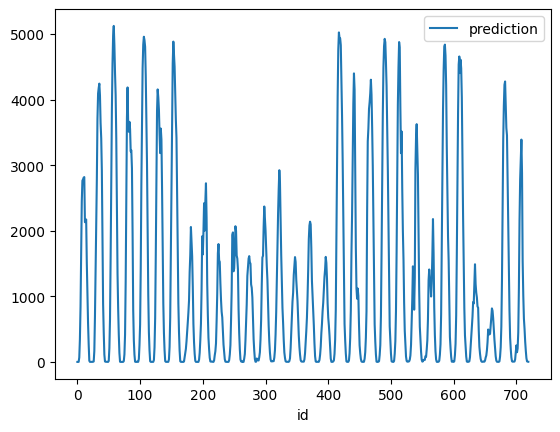
#### Location B
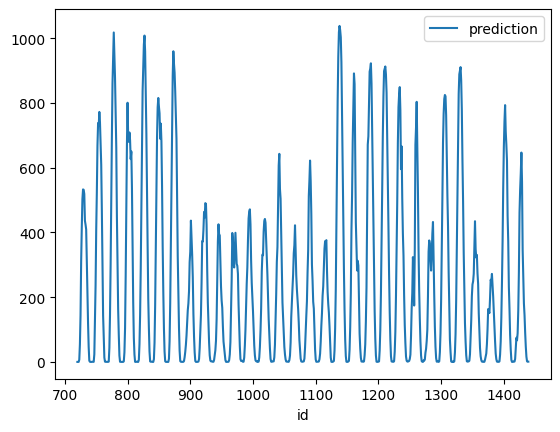

#### Location C
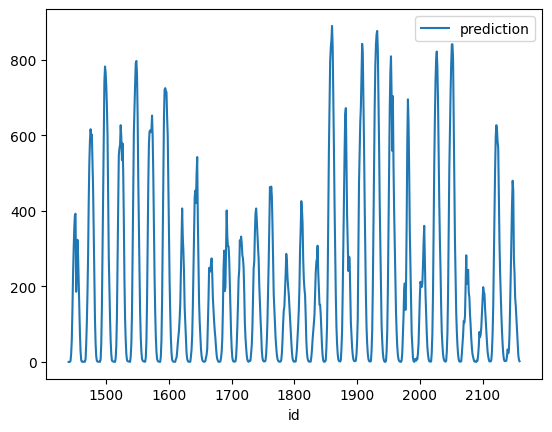

### 3. Models
This section contains all model classes used to generate submitted Kaggle predictions. Models are ordered chronologically by the first date they were used to generate a submission.

#### MetaModel

Description: 
Abstract class which provides a framework for implementing subsequent models. MetaModel contains a test function common to all classes, which standardizes how models are evaluated (MAE-based). It also contains three abstract functions which are implemented in the actual models, namely preprocess, train, and predict.

In [ ]:
class MetaModel(ABC):     
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = None

        return

    # Denne df-en må ha y som kolonne
    def test(self, df: pd.DataFrame, n_splits=5):
        """
            Expanding window cross-validation, df must have y in it for testing against predictions
        """
        print(f"Testing {self.model_name}")
        column_names = df.columns.tolist()
        if 'y' not in column_names:
            raise Exception(f"Missing observed y in columns. Available are {column_names}")

        # This is unecessary because we already clean it when calling train
        # drop_y_with_na
        df = df.dropna(subset=['y'], inplace=False)

        MAE_values = []
        MSE_values = []

        # tscv = TimeSeriesSplit(n_splits=n_splits)
        kf =KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_index, test_index in kf.split(df):
            train_partition = df.iloc[train_index]
            valid_partition = df.iloc[test_index]

            self.train(train_partition)
            predictions = self.predict(valid_partition)
            
            y_true = valid_partition['y']
            y_pred = predictions['y_pred']

            MAE = mean_absolute_error(y_true, y_pred)
            MAE_values.append(MAE)

            MSE_values.append((y_pred - y_true).mean())

            print(f"Run {len(MAE_values)} MAE =", MAE)

        print("Mean Signed Error vals", MSE_values)
        average_mae = statistics.mean(MAE_values)
        print("MAE Vals: MEAN:", average_mae, 'ALL:' , MAE_values)
        
        return MAE_values
    
    @abstractmethod
    def preprocess(df: pd.DataFrame) -> pd.DataFrame:
        """
            Takes in single-index (datetime as index) df, and returns df with only desired features
        """    
        pass
    
    @abstractmethod
    def train(df: pd.DataFrame):
        """

        """
        pass

    @abstractmethod
    def predict(df: pd.DataFrame):
        """
            Runs trained model on on input df, preprocessing the df first and then returns datetime and y_pred
        """
        pass

#### 1. Naive estimator

Description: 
For each location, the model predicts pv_measurement to be the average pv_measurement for that location. 

In [ ]:
class NaiveModel(MetaModel):
    
    def __init__(self):
        super().__init__("Naive Model")
        
    def preprocess(self, df):
        """
        """
        temp_df = df.copy()

        return temp_df

    def train(self, df):
        """
        """
        df = self.preprocess(df)

        self.model = df.y.mean()


    def predict(self, df):
        df = self.preprocess(df)

        df['y_pred'] = self.model

        return df[['ds', 'y_pred']].copy()

#### 2. Linear Regression

Description: The Linear Regression Model predicts pv_measurement by fitting a linear relationship between total radiation (sum of diffuse and direct radiation) measured over an hour and the pv_measurement, using simple linear regression.

In [ ]:
class LinearRegressionModel(MetaModel):
    
    def __init__(self):
        super().__init__("Linear Regression")
        
    def preprocess(self, df):
        """
        """
        temp_df = df.copy()

        temp_df['total_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']

        temp_df['total_rad_1h:J'].ffill(inplace=True)
        temp_df['total_rad_1h:J'].bfill(inplace=True)

        temp_df['total_rad_1h:J'].fillna(temp_df['total_rad_1h:J'].interpolate().cummax(), inplace=True)

        if('y' in temp_df.columns.tolist()):
            temp_df['y'].fillna(df['y'].interpolate().cummax(), inplace=True)

        return temp_df

    def train(self, df):
        """
        """
        df = self.preprocess(df)

        self.model = LinearRegression()
        self.model.fit(df['total_rad_1h:J'].values.reshape(-1, 1), df['y'].values.reshape(-1, 1))


    def predict(self, df):
        df = self.preprocess(df)

        y_preds = self.model.predict(df['total_rad_1h:J'].values.reshape(-1, 1))
        y_preds_arr = np.array(y_preds)

        out_df = pd.DataFrame(y_preds_arr, columns=["y_pred"])        

        return out_df

#### 3. Prophet

Description: The Prophet Model predicts pv_measurement using Facebook's Prophet algorithm, optionally focusing on observed data for specific locations and incorporating highly correlated features (correlation greater than 0.6 with the target variable) or the total radiation measured over an hour as regressors.

In [1]:
class ProphetModel(MetaModel):
    """
    Hyperparameters, default in parentheses:

        'C_observed_only' (False) - whether location C should only use observed data
        'features_by_corr0.6' (True) - use features with corr > 0.6 with y, if false uses 'total_rad_1h:J'
    """
    
    def __init__(self, hyperparameters = None):
        super().__init__("Prophet Model")
        self.hyperparameters = hyperparameters
        
    def preprocess(self, df):
        """
        """
        df = df.copy()

        if self.hyperparameters is not None and self.hyperparameters["C_observed_only"]:
            if location == "C":
                df = df[df.weather_data_type == 'observed'].copy()


        df['total_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']

        df = df.dropna(axis=0, how="all", subset="total_rad_1h:J")

        if('y' in df.columns.tolist()):
            df = df.dropna(axis=0, how="all", subset="y")

        df.fillna(0, inplace=True)
        
        return df

    def train(self, df):
        """
        """
        df = self.preprocess(df)

        self.prophet_model = Prophet()
        
        feat_find = df.corr().y.apply(abs).sort_values(ascending=False)
        features = feat_find[feat_find > 0.6].index.tolist()
        features.remove("y")
        
        if self.hyperparameters is not None and not self.hyperparameters["features_by_corr0.6"]:
            features = ['total_rad_1h:J']
        
        for feat in features:
            self.prophet_model.add_regressor(feat)

        self.prophet_model.fit(df)


    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        forecast = self.prophet_model.predict(df)
        # self.prophet_model.plot_components(forecast)
        # fig = prophet_model.plot_components(forecast)
        temp_ret = forecast[['ds', 'yhat']].rename(columns={'yhat':'y_pred'})

        # force negative values to zero
        temp_ret.y_pred = temp_ret.y_pred.apply(lambda a : max(a, 0))

        return temp_ret

NameError: name '__file__' is not defined

#### 4 XG Boost Rev1

Description: The XGBoost Model employs the XGBoost algorithm to predict pv_measurement, preprocessing data to handle missing values, encoding locations as factors, using six selected features.

In [2]:
class XGBoostModel(MetaModel):

    def __init__(self):
        super().__init__("XGBoost")

    def preprocess(self, df):
        temp_df = df.copy()

        # SETTING ALL NAN TO 0 CONFORMING TO XGBOOST
        temp_df.fillna(0, inplace=True)

        print("NUM NANS AFTER FILLNA:", temp_df.isna().sum())


        temp_df['location'] = pd.factorize(temp_df['location'])[0]
        
        if 'diffuse_rad_1h:J' in df.columns and 'direct_rad_1h:J' in df.columns:
            temp_df['total_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']

        temp_df.dropna(axis=0, how="all", subset=["total_rad_1h:J"], inplace=True)

        if 'ds' in temp_df.columns:
            try:
                temp_df['ds'] = pd.to_datetime(temp_df['ds'])
                temp_df['hour_of_day'] = temp_df['ds'].dt.hour
                temp_df['month'] = temp_df['ds'].dt.month
            except:
                print("Error converting ds to datetime")

        if 'y' in temp_df.columns:
            temp_df.dropna(axis=0, how="all", subset=["y"], inplace=True)

        selected_cols = [
            'location', 
            'total_rad_1h:J',
            'hour_of_day', 
            'month', 
            'clear_sky_energy_1h:J', 
            'sun_elevation:d'
        ]

        if 'y' in df.columns:
            selected_cols.append('y')


        return temp_df[selected_cols]

    def train(self, df):
        df = self.preprocess(df)
        features = [col for col in df.columns if col != 'y']
        X = df[features]
        y = df['y']
        self.model = xgb.XGBRegressor()
        self.model.fit(X, y)

    def predict(self, df):
        df = self.preprocess(df)
        features = [col for col in df.columns if col != 'y']
        X = df[features]
        y_preds = self.model.predict(X)
        return pd.DataFrame({'y_pred': y_preds})

KeyboardInterrupt: 

#### 5. XG Boost Henrik

Description:
Similar to model 4 (XGBoost rev1) but with all features, sample importance, and use of hyperparameters.

In [ ]:
class XGBoostHenrik(MetaModel):
    
    def __init__(self, features = None):
        super().__init__("XGBoost Henrik")
        self.features = []
        if features is not None:
            self.features = features  # Use the provided features if not None
        else:
            self.features.extend(['is_estimated', 'sample_importance',
                              'dayofyear',
                             'hour',
                            'total_rad_1h:J',
        'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms'])
            
        
    def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns        
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

         # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO XGBOOST
        temp_df.fillna(0, inplace=True)

        #####################################################################################

        # DROPPING UNEEEDED FEATURES
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df

    def train(self, df):
        """
        """

        temp_df = self.preprocess(df)

        # Separate features and target
        X = temp_df.drop('y', axis=1, inplace=False).copy().values
        y = temp_df['y'].copy().values

        # Train test split
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

        params = {
            'objective': "reg:absoluteerror",
            'eta': 0.25,
            'max_depth': 8,
            'lambda': 1
        }

        # Setup XGB
        self.model = xgb.XGBRegressor(**params)

        self.model.fit(
            X,
            y,
            verbose=True,
        )



    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        features = [col for col in df.columns if col != 'y']
        X = df[features].values
        y_preds = self.model.predict(X)

        # Set all negative predictions to 0
        y_preds = np.maximum(y_preds, 0)

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df

#### 6. Tree Composite 

Description: The TreeComposite Henrik Model integrates predictions from XGBoost, CatBoost, and LightGBM models, each trained on a set of meteorological and temporal features, and then computes the average of these predictions to estimate pv_measurement.

In [ ]:
from xgboost_henrik import XGBoostHenrik
from catboost_henrik import CatBoostHenrik
from lightgbm_henrik import LightBGMHenrik

class TreeCompositeHenrik(MetaModel):
    
    def __init__(self):
        super().__init__("TreeComposite Henrik")
        self.features = []
        
        self.features.extend(['month',
                             'hour',
                            'total_rad_1h:J',
        'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms'])
                                    
        
    def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns        
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        ml.utils.map_hour_to_seasonal(temp_df, 'hour')

        temp_df['month'] = temp_df['ds'].dt.month
        ml.utils.map_month_to_seasonal(temp_df, 'month')
   
        # SETTING NAN TO 0 CONFORMING TO XGBOOST
        temp_df.fillna(0, inplace=True)

        #####################################################################################

        # DROPPING UNEEEDED FEATURES
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df

    def train(self, df: MetaModel):
        """
        """

        self.models = {
            "XGBoost Henrik": XGBoostHenrik(),
            "CatBoost Henrik": CatBoostHenrik(),
            "LightGBM Henrik": LightBGMHenrik()
        }

        for key in self.models:
            self.models[key].train(df)



    def predict(self, df):
        """
        """
        
        all_preds = None

        out_df = None

        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

            
        avg_series = all_preds.mean(axis=1)

        print("The different models produced the following predictions:")
        print(all_preds)
        print("Averages")
        print(avg_series)

        return pd.DataFrame(avg_series, columns=['y_pred'])

    

#### 7. CatBoost Henrik

Description: The CatBoost Henrik Model utilizes CatBoost, an open-source ML library used for gradient boosting on decision trees. Includes hyperparameters.

In [ ]:
class CatBoostHenrik(MetaModel):
    
    def __init__(self, features=None, random_state=42):
        super().__init__("CatBoost")

        self.random_state = random_state

        # Our CatBoost model supports using internal features. But, if you look at 
        # CatComposite you will see that models are passed in for each model.
        if(features):
            self.features = features
        else:
            self.features = []
            self.features.extend(['sample_importance',
                                'dayofyear',
                                'hour',
                                'total_rad_1h:J',
                                'is_day:idx',
            'absolute_humidity_2m:gm3',
            'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
            'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
            'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
            'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
            'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
            'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
            'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
            'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
            'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
            'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
            't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
            'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
            'wind_speed_w_1000hPa:ms'])

    def preprocess(self, df: pd.DataFrame):
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns        
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

        # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        # ! CatBoost doesn't use this for training-emphasis, but it needs to be made to avoid an error !
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        # Make total radiation feature
        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day, month, and day-of-year to make them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['month'] = temp_df['ds'].dt.month
        temp_df['month'] = (np.sin(2 * np.pi * (temp_df['month'])/ 12) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO CatBoost
        temp_df.fillna(0, inplace=True)
        #####################################################################################

        # Dropping features that aren't needed from the DF
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df

    def train(self, df):
        temp_df = self.preprocess(df)

        # Separate features and target
        X = temp_df.drop('y', axis=1, inplace=False).copy().values
        y = temp_df['y'].copy().values

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=self.random_state)

        # Parameters found through grid-search and some manual tuning (CatBoostRegressor.grid_search())
        params = {
            'objective': "MAE",
            'learning_rate': 0.02,
            'depth': 6,
            'iterations': 8000,
            'logging_level': 'Silent',
            'l2_leaf_reg': 5
        }

        # Set-up model with above features
        self.model = cb.CatBoostRegressor(**params)
        
        self.model.fit(
             X_train,
             y_train,
             verbose=True,
             eval_set=(X_test, y_test),
        )

    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        features = [col for col in df.columns if col != 'y']
        X = df[features].values
        y_preds = self.model.predict(X)

        # Set all negative predictions to 0
        y_preds = np.maximum(y_preds, 0)

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df
    

#### 8. LightGBM Henrik

Description: The LightBGM Henrik Model employs LightGBM with hyperparameters.

In [ ]:
class LightBGMHenrik(MetaModel):
    
    def __init__(self, features=None):
        super().__init__("LightBGM Henrik")

        self.features = []

        if features:
            self.features = features
        
        else:
            self.features.extend(['sample_importance',
                                'dayofyear',
                                'hour',
                                'total_rad_1h:J',
                                'is_day:idx',
            'absolute_humidity_2m:gm3',
            'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
            'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
            'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
            'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
            'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
            'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
            'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
            'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
            'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
            'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
            't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
            'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
            'wind_speed_w_1000hPa:ms'])
                                      
        
    def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        has_target = 'y' in temp_df.columns
        
        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

         # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['month'] = temp_df['ds'].dt.month
        temp_df['month'] = (np.sin(2 * np.pi * (temp_df['month'])/ 12) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO LGBM
        temp_df.fillna(0, inplace=True)
    
        #####################################################################################

        # DROPPING UNEEEDED FEATURES
        if(has_target):
            features_w_y = self.features + ['y']
            temp_df = temp_df[features_w_y]

        else:
            temp_df = temp_df[self.features]

        return temp_df

    def train(self, df):
        """
        """

        temp_df = self.preprocess(df)

        # Separate features and target
        sample_importance = temp_df['sample_importance']
        X = temp_df.drop(['y','sample_importance'], axis=1, inplace=False).copy().values
        y = temp_df['y'].copy().values

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

        num_iterations = 2000
        early_stopping_percentage = 0.1

        params = {
            'objective': "mae",
            'learning_rate': 0.1,
            'num_leaves': 128,
            'zero_as_missing': True,
            'num_iterations': num_iterations
        }


        # Setup XGB
        self.model = lgbm.LGBMRegressor(**params)

        self.model.fit(
            X_train,
            y_train,
            eval_set = (X_test, y_test),
            #sample_weight = sample_importance,
            eval_metric = 'mae',
            early_stopping_rounds = round(num_iterations * early_stopping_percentage)
        )



    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        features = [col for col in df.columns if col not in ['y', 'sample_importance']]
        X = df[features].values
        y_preds = self.model.predict(X)

        # Set all negative predictions to 0
        y_preds = np.maximum(y_preds, 0)

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df

#### 9. AutoML H20

Tried this once without success. Low effort attempt - code was deleted and could not be retrieved.

#### 10. Autogluon Henrik

Description: AutoGluon with hyperparameters.

In [ ]:
class AutoGluonHenrik(MetaModel):
    
    def __init__(self, time_limit=None, excluded_models: list = []):
        super().__init__("AutoGluon Henrik")

        self.time_limit = time_limit
        self.excluded_models = excluded_models

        self.features = []
        
        self.features.extend(['sample_importance',
                            'total_rad_1h:J',
        'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms'])
        
        """

        self.features.extend(['total_rad_1h:J', 'month', 'hour', 'sun_elevation:d', 'effective_cloud_cover:p'])
        """
                            
    def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        has_target = 'y' in df.columns

        if has_target:
            temp_df = temp_df[temp_df['y'].notna()]

        ##################################################################################### 
        # FEATURE ENGINEERING
        #####################################################################################

        # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
        temp_df['sample_importance'] = 1
        temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                    (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
        
        temp_df.loc[(temp_df['ds'].dt.month == 7) &
                    (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2
        
        # Add is_estimated parameter
        temp_df['is_estimated'] = (temp_df['weather_data_type'] == 'estimated')
        temp_df['is_estimated'] = temp_df['is_estimated'].astype(int)

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)
   
        # SETTING NAN TO 0 CONFORMING TO XGBOOST
        temp_df.fillna(0, inplace=True)

        #####################################################################################
        if(has_target):
            
            return temp_df[self.features + ['y']]
        else:
            return temp_df[self.features]

    def train(self, df):
        """
        """
        temp_df = self.preprocess(df)


        train_data = TabularDataset(temp_df)

        self.model = TabularPredictor(
            label='y',
            eval_metric='mean_absolute_error',
            problem_type='regression',
            sample_weight='sample_importance',
            weight_evaluation=True
        ).fit(train_data,
              time_limit = self.time_limit,
              excluded_model_types = self.excluded_models,
              presets=['good_quality']
              )


    def predict(self, df):
        """
        """
        df = self.preprocess(df)

        features = [col for col in df.columns if col != 'y']
        X = df[features]

        y_preds = self.model.predict(X)
        print("AUTOGLUON MODEL OVERVIEW:")
        print(self.model.get_model_names())
       

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df

#### 11. LGBM Composite

Description: Average of the predictions of several LGBM Henrik models. Use of random features to create different models.

In [ ]:
from lightgbm_henrik import LightBGMHenrik

class LGBMCompositeHenrik(MetaModel):
    
    def __init__(self, num_models=10):
        super().__init__("LGBMComposite Henrik")

        self.num_models = num_models
        self.common_features = ['sample_importance', 'is_estimated','dayofyear',
                                'is_day:idx',
                             'hour', 'month',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
        self.random_features = ['absolute_humidity_2m:gm3',
                                'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                                'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                                'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
                                'direct_rad_1h:J', 'fresh_snow_3h:cm',
                                'precip_5min:mm','precip_type_5min:idx', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                                'sfc_pressure:hPa','snow_water:kgm2',
                                'super_cooled_liquid_water:kgm2',
                                't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                                'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
                           
        
    def preprocess(self, df: pd.DataFrame):

        return df

    def train(self, df: pd.DataFrame):
        df = self.preprocess(df)
        num_rand_features = round(len(self.random_features) * 0.85)

        features = dict()

        self.models = dict()

        for i in range(self.num_models):
            temp_rand_features = random.sample(self.random_features, num_rand_features)
            features[i] = self.common_features + temp_rand_features
            self.models[f'LGBM_{i} Henrik'] = LightBGMHenrik(features = features[i])

            print(f'LGBM_{i} Henrik')

        for key in self.models:
            self.models[key].train(df)



    def predict(self, df):
        """
        """
        
        all_preds = None

        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

            
        avg_series = all_preds.mean(axis=1)

        avg_series = np.maximum(avg_series, 0)

        return pd.DataFrame(avg_series, columns=['y_pred'])

#### 12. Composite Composite

Description: Average of composite catboost, composite xg_boost, and autogluon.

In [ ]:
from models_here_hahah.cat_composite import CatCompositeHenrik
from xg_boost_composite import XGBoostComposite
from autogluon_henrik import AutoGluonHenrik, AutoGluonJacob
from catboost_henrik import CatBoostHenrik

class CompositeCompositeHenrik(MetaModel):
    
    def __init__(self):
        super().__init__("CompositeComposite Henrik")

        self.common_features = ['dayofyear',
                             'hour',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
        self.random_features = ['absolute_humidity_2m:gm3',
                            'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                            'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                            'dew_point_2m:K', 'elevation:m',
                            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
                            'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
                            'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
                            'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                            'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
                            'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'super_cooled_liquid_water:kgm2',
                            't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                            'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                            'wind_speed_w_1000hPa:ms']
                                    
        
    def preprocess(self, df: pd.DataFrame):

        return df.copy()

    def train(self, df: MetaModel):
        
        # Excluded AutoGluon models (https://auto.gluon.ai/0.4.0/api/autogluon.predictor.html)
        excluded_ag_models = None ### NOT GOOD!!!!!!! DONT EXCLUDEEEE

        df = df.copy()

        df.drop(df[(df['ds'].dt.month > 9) & (df['ds'].dt.month < 4)].index, inplace = True)

        self.models = {
            "XGBoost Composite": XGBoostComposite(),
            #AutoGluon 5min": AutoGluonHenrik(time_limit=60*30, excluded_models=excluded_ag_models),
            "AutoGluonJacob 10min": AutoGluonJacob(time_limit=60*10),
            "CatComposite x20": CatCompositeHenrik(num_models=20)
        }

        for key in self.models:
            self.models[key].train(df)



    def predict(self, df):
        """
        """
        
        all_preds = None

        out_df = None

        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

            
        avg_series = all_preds.mean(axis=1)

        print("The different models produced the following predictions:")
        print(all_preds)

        avg_series = np.maximum(avg_series, 0)

        return pd.DataFrame(avg_series, columns=['y_pred'])

#### 13. XG Boost Composite

Description: Average of several xg_boost models. Use of random features to create different models.

In [ ]:
class XGBoostComposite(MetaModel):
    
    def __init__(self):
        super().__init__("XGBoost Composite")

        self.common_features = ['is_estimated','dayofyear',
                             'hour',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
        self.random_features = ['absolute_humidity_2m:gm3',
                            'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                            'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                            'dew_point_2m:K', 'elevation:m',
                            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
                            'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
                            'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
                            'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                            'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
                            'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'super_cooled_liquid_water:kgm2',
                            't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                            'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                            'wind_speed_w_1000hPa:ms']
                    
        
    def preprocess(self, df: pd.DataFrame):
        return df.copy()

    
    def train(self, df: pd.DataFrame, use_meta_learner=True):
        num_models = 30
        num_rand_features = round(len(self.random_features) * 0.8)  
        df = df.copy()
        df['month'] = df['ds'].dt.month

        meta_train_df = df[(df['month'] == 5) | (df['month'] == 6) | (df['month'] == 7)].sample(frac=0.5)
        print("Meta-train % of full DF", len(meta_train_df)/len(df))
        train_df = df.loc[~df.index.isin(meta_train_df)]

        features = dict()
        self.models = dict()

        for i in range(num_models):
            temp_rand_features = random.sample(self.random_features, num_rand_features)
            features[i] = self.common_features + temp_rand_features
            self.models[f'XGBOOST_{i}'] = XGBoostHenrik(features = features[i])

        for key in self.models:
            print("Training model", key)
            self.models[key].train(train_df)
        
        if (use_meta_learner):                        
            y_preds = self.predict(meta_train_df, meta_training=True)

            self.meta_learner = LinearRegression(fit_intercept=False, positive=True)
            self.meta_learner.fit(y_preds, meta_train_df['y'])

            
            self.meta_learner.coef_ = np.full(shape = self.meta_learner.coef_.shape, fill_value = 1/num_models)

            print(self.meta_learner.coef_)
    
    def predict(self, df, meta_training = False):
        """
        """
        all_preds = None
        out_df = None
        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

        if (meta_training):
            print("RETURNING ALL_PREDS")
            return pd.DataFrame(all_preds)

        #print("THIS HAS GONE TOO FAR!")

        # Use meta-learner to calculate final output

        out_np = self.meta_learner.predict(all_preds)
        #print(out_np)

        
        return pd.DataFrame(out_np, columns=['y_pred'])

#### 14. Autogluon Jacob

Description: Autogluon with hyperparameters, sample weigtg, and tuning data.

In [3]:
class AutoGluonJacob(MetaModel):
    
    def __init__(self, time_limit=60*20):
        super().__init__("AutoGluon Jacob")

        # autogluon features
        # TabularPredictor (usage : **params_TabularPredictor)
        self.params_TabularPredictor = \
            {
                'label': 'y',
                'problem_type': 'regression', 
                'eval_metric': 'mean_absolute_error',
                'verbosity': 2,
            }
        # TabularPredictor.fit
        self.params_TabularPredictor_fit = \
            {
                'time_limit': time_limit,
                'presets': 'high_quality', # [‘best_quality’, ‘high_quality’, ‘good_quality’, ‘medium_quality’, ‘optimize_for_deployment’, ‘interpretable’, ‘ignore_text’]
                'hyperparameters': 'default',
                # 'auto_stack': False,
                # 'num_bag_folds': None, # set automatically by auto_stack True
                # 'num_bag_sets': None, # set to 20 because of auto_stack
                # 'num_stack_levels': 3, # set automatically by auto_stack True
                'hyperparameter_tune_kwargs': 'random', # None to disable
                # 'refit_full': True,
                # 'feature_prune_kwargs': {}, # If None, do not perform feature pruning. If empty dictionary, perform feature pruning with default configurations.
            }

        self.use_tuning_data = True # 'sample_weight', 'random'
        self.use_sample_weight = True

        if self.use_sample_weight: # auto_weight a feature that exists
            self.params_TabularPredictor['sample_weight'] = 'sample_importance'

        

    def preprocess(self, df: pd.DataFrame):
        """
        """
        temp_df = df.copy()

        temp_df['total_rad_1h:J'] = temp_df['diffuse_rad_1h:J'] + temp_df['direct_rad_1h:J']    
        
        # Extracting hour-of-day and month, and making them cyclical
        temp_df['hour'] = temp_df['ds'].dt.hour
        temp_df['hour'] = (np.sin(2 * np.pi * (temp_df['hour'] - 4)/ 24) + 1) / 2

        temp_df['dayofyear'] = temp_df['ds'].dt.day_of_year
        temp_df['dayofyear'] = np.sin(2 * np.pi * (temp_df['dayofyear'] - 80)/ 365)

        # temp_df['year'] = temp_df['ds'].dt.hour
        temp_df['month'] = temp_df['ds'].dt.month
        # temp_df['day'] = temp_df['ds'].dt.day
        # temp_df['dayofweek'] = temp_df['ds'].dt.dayofweek

        if self.use_sample_weight:
            # Emphasize test start-end: Starting date: 2023-05-01 00:00:00 Ending data 2023-07-03 23:00:00
            temp_df['sample_importance'] = 1
            temp_df.loc[(temp_df['ds'].dt.month >= 5) & 
                        (temp_df['ds'].dt.month < 7), 'sample_importance'] = 2
            
            # temp_df.loc[(temp_df['ds'].dt.month == 7) &
            #             (temp_df['ds'].dt.day <= 4), 'sample_importance'] = 2



        return temp_df.drop(columns=['ds'])#[self.common_features + self.random_features + (['y'] if 'y' in temp_df else [])].copy()

    def train(self, df):
        """
        """
        temp_df = self.preprocess(df)

        if self.use_tuning_data:

            tuning_data = temp_df[(temp_df['month'] == 5) | (temp_df['month'] == 6)].sample(frac=0.5, random_state=42)
            train_data = TabularDataset(temp_df[~temp_df.isin(tuning_data.to_dict(orient='list')).all(1)])
            # train_data, tuning_data = train_test_split(df, test_size=0.1, random_state=42)
            train_data = TabularDataset(train_data)

            self.model = TabularPredictor(**self.params_TabularPredictor).fit(train_data, tuning_data=tuning_data, use_bag_holdout=True, **self.params_TabularPredictor_fit)
        else:
            train_data = TabularDataset(temp_df)

            self.model = TabularPredictor(**self.params_TabularPredictor).fit(train_data, **self.params_TabularPredictor_fit)

    def predict(self, df):
        """
        """
        print("Predict called")
        df = self.preprocess(df)

        features = [col for col in df.columns if col != 'y']
        X = df[features]



        y_preds = self.model.predict(X)
        # print(self.model.leaderboard())
       

        out_df = pd.DataFrame(data={'y_pred': y_preds})

        return out_df

ModuleNotFoundError: No module named 'autogluon'

#### 15. CatBoost Composite

Description: Average of catboost models, using random features and random seeds on train-test-split to create different models.

In [ ]:
class CatCompositeHenrik(MetaModel):
    
    def __init__(self, num_models=20):
        super().__init__("CatComposite Henrik")

        self.num_models = num_models

        # Set of features all models will have in common, selected
        # those that have had high importance in prior trainings.
        self.common_features = ['sample_importance', 'is_estimated','dayofyear',
                                'is_day:idx',
                             'hour', 'month',
                            'total_rad_1h:J',
                            'sun_elevation:d',
                            'sun_azimuth:d',
                            'is_in_shadow:idx',
                            'effective_cloud_cover:p']
        
        # The set of features from which each models samples at random
        self.random_features = ['absolute_humidity_2m:gm3',
                                'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
                                'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
                                'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
                                'direct_rad_1h:J', 'fresh_snow_3h:cm',
                                'precip_5min:mm','precip_type_5min:idx', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
                                'sfc_pressure:hPa','snow_water:kgm2',
                                'super_cooled_liquid_water:kgm2',
                                't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
                                'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
             
    def preprocess(self, df: pd.DataFrame):
        # All preprocessing is done by the individual CatBoost models, so nothing here.
        return df.copy()
    
    def train(self, df: pd.DataFrame):
        num_models = self.num_models

        # How many of the features to be random, this gives some variations in all data and reduces overfitting.
        # Each model picks 90% of the features from the "random_features" pool. 90% was found through experimenting
        # and have given the best results.
        num_rand_features = round(len(self.random_features) * 0.9)

        # Manually set random_states to be used for each models for reproducability
        random_states = [i for i in range(33, 33 + num_models)]

        # Duplicate rows for months 5, 6, and 7 to overfit learning for the months we intend to predict
        df = df.copy()
        df['month'] = df['ds'].dt.month

        selected_months = df[(df['month'] == 5) | (df['month'] == 6) | (df['month'] == 7)].copy()
        train_df = pd.concat([df, selected_months], ignore_index=True)

        # Set-up models
        features = dict()
        self.models = dict()

        for i in range(num_models):
            random.seed(random_states[i])
            temp_rand_features = random.sample(self.random_features, num_rand_features)
            features[i] = self.common_features + temp_rand_features
            self.models[f'CATBOOST_{i}'] = CatBoostHenrik(features = features[i], random_state=random_states[i])

        # Train each model
        for key in self.models:
            print("Training model", key)
            self.models[key].train(train_df)     
    
    def predict(self, df):
        all_preds = None
        out_df = None

        # Get predictions from all the sub-models
        for key in self.models:
            y_pred = self.models[key].predict(df)['y_pred']
            if(all_preds is None):
                all_preds = pd.DataFrame(y_pred)
            else:
                all_preds[key] = y_pred.values

        # Take equally weighted average of models
        out_np = all_preds.mean(axis=1)

        return pd.DataFrame(out_np, columns=['y_pred'])